In [252]:
# Import required packages

#!pip install neo4j

import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth

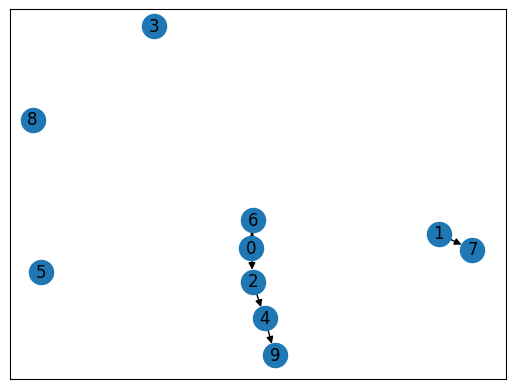

In [253]:
# Create and draw graph

n = 10
p = 0.05

G = nx.erdos_renyi_graph(n, p, directed = True)


nx.draw_networkx(G, with_labels = True)
plt.show()

In [254]:
# Adjust graph so there are no 0 in degree nodes (adding edges that aren't loops)

for deg in G.in_degree():
  if deg[1] == 0:
    out_neighbor = random.randint(0,n)
    while out_neighbor == deg[0]:
      out_neighbor = random.randint(0,n)
    G.add_edge(deg[0],out_neighbor)


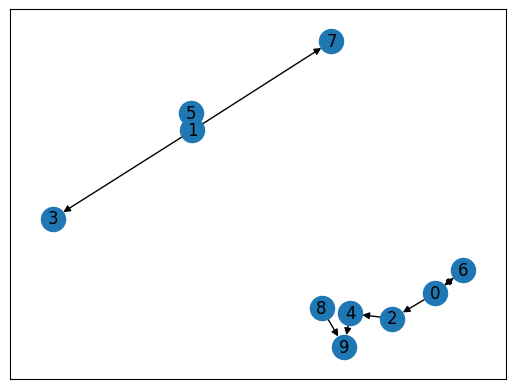

In [255]:
# Draw graph to see that edges have been added

nx.draw_networkx(G, with_labels = True)
plt.show()

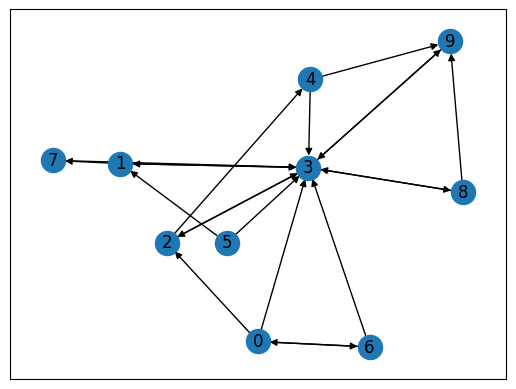

In [256]:
# Simulate home button by adding edges to home node and from home node to most nodes and draw graph again

out_degs = []

for deg in G.out_degree():
  out_degs.append(deg[1])

home = out_degs.index(max(out_degs))


likelihood_link_from_home = 40

for node in range(n):
  random_value = random.randint(0,100)
  if node != home:
    G.add_edge(node, home)
    if random_value < likelihood_link_from_home:
      G.add_edge(home, node)

nx.draw_networkx(G, with_labels = True)
plt.show()

In [257]:
# perform random walks in graph

def random_walk(graph:nx.Graph, start_node:int = 0, walk_length:int = 1) -> list[int]:

    sequence = [start_node]

    for _ in range(walk_length):
        neighbours = [neighbour for neighbour in graph.neighbors(start_node)]
        if neighbours == []:
          return sequence
        selected_neighbour = random.choice(neighbours)
        sequence.append(selected_neighbour)
        start_node = selected_neighbour

    return sequence

In [258]:
# example of random walks in graph

walk_length_max = 5
amount_of_visitors = 1000

# for _ in range(10):
#    print(random_walk(G, random.randrange(n), random.randrange(0, walk_length_max)))

# Simulating visitor behavior

visits = []
fraction_of_visits_through_home = 10 # every i-th user entering through home page

for visit in range(amount_of_visitors):
  if visit % fraction_of_visits_through_home == 0:
    visits.append(random_walk(G, home, random.randrange(0, walk_length_max)))
  else:
    visits.append(random_walk(G, random.randrange(n), random.randrange(0, walk_length_max)))

# Count amount of users taking the same path (path at least of length 2)

path_dict = {}

for visit in visits:
  if len(visit) > 1:
    if tuple(visit) in path_dict:
      path_dict[tuple(visit)] += 1
    else:
      path_dict[tuple(visit)] = 1


# Disregard neglegible traffic / simulate more realistic traffic with fewer random walks and more users:

neglegible_traffic_threshold = 5

filtered_path_dict = {}

for item in path_dict.items():
  if item[1] > neglegible_traffic_threshold:
    filtered_path_dict[item[0]] = item[1]



for key in sorted(filtered_path_dict.keys()):
  print(key, filtered_path_dict[key])

(0, 2) 7
(0, 2, 4) 7
(0, 3) 7
(0, 6) 7
(1, 3) 9
(1, 7) 18
(1, 7, 3) 10
(2, 3) 13
(2, 4) 14
(2, 4, 9, 3) 9
(3, 1) 10
(3, 1, 3) 6
(3, 2) 12
(3, 2, 4, 9) 6
(3, 8, 9) 7
(3, 9) 13
(4, 3) 8
(4, 9) 10
(4, 9, 3) 7
(5, 1) 10
(5, 3) 9
(6, 0) 9
(6, 3) 6
(6, 3, 1) 6
(7, 3) 19
(7, 3, 1) 6
(7, 3, 9, 3) 7
(8, 3) 10
(8, 9) 9
(8, 9, 3) 9
(9, 3) 17
(9, 3, 8) 8


In [259]:
# Import into Neo4j

# Adjust URI and AUTH to personal Neo4j instance
#
# URI = "<URI for Neo4j database>"
# AUTH = ("<Username>", "<Password>")

URI = "bolt://44.223.108.111:7687"
with open("neo4j_auth.txt", 'r') as lines:
  content = lines.read().strip()
  AUTH = tuple(content.split(','))

# create nodes (faster if exported to graphml and imported into Neo4j or using nxneo4j)

def clear_graph_tx(tx):
  tx.run("MATCH (n) DETACH DELETE n")

def create_node_tx(tx, id):
  tx.run("CREATE (n:Node {id: $id})", id = id)

def create_edge_tx(tx, id1, id2, path, users):
  tx.run("MATCH (x:Node{id: $id1}), (y:Node{id: $id2}) MERGE (x)-[r:TRAFFIC{path: $path, users: $users}]->(y)", id1 = id1, id2 = id2, path = path, users = users)



with GraphDatabase.driver(URI, auth=AUTH) as driver:
  with driver.session(database="neo4j") as session:
    session.execute_write(clear_graph_tx)
    for node in range(n):
      session.execute_write(create_node_tx, node)
    for path, users in filtered_path_dict.items():
      for start_index in range(len(path)-1):
        end_index = start_index + 1
        session.execute_write(create_edge_tx, path[start_index], path[end_index], list(path), users)


3 9 (3, 9) 13
7 3 (7, 3) 19
4 3 (4, 3) 8
2 4 (2, 4, 9, 3) 9
4 9 (2, 4, 9, 3) 9
9 3 (2, 4, 9, 3) 9
6 3 (6, 3) 6
8 9 (8, 9) 9
0 2 (0, 2) 7
3 2 (3, 2, 4, 9) 6
2 4 (3, 2, 4, 9) 6
4 9 (3, 2, 4, 9) 6
3 1 (3, 1, 3) 6
1 3 (3, 1, 3) 6
9 3 (9, 3, 8) 8
3 8 (9, 3, 8) 8
7 3 (7, 3, 1) 6
3 1 (7, 3, 1) 6
2 3 (2, 3) 13
3 8 (3, 8, 9) 7
8 9 (3, 8, 9) 7
4 9 (4, 9, 3) 7
9 3 (4, 9, 3) 7
6 0 (6, 0) 9
9 3 (9, 3) 17
5 3 (5, 3) 9
3 2 (3, 2) 12
7 3 (7, 3, 9, 3) 7
3 9 (7, 3, 9, 3) 7
9 3 (7, 3, 9, 3) 7
0 2 (0, 2, 4) 7
2 4 (0, 2, 4) 7
1 7 (1, 7, 3) 10
7 3 (1, 7, 3) 10
4 9 (4, 9) 10
1 3 (1, 3) 9
1 7 (1, 7) 18
8 9 (8, 9, 3) 9
9 3 (8, 9, 3) 9
0 3 (0, 3) 7
8 3 (8, 3) 10
5 1 (5, 1) 10
0 6 (0, 6) 7
3 1 (3, 1) 10
2 4 (2, 4) 14
6 3 (6, 3, 1) 6
3 1 (6, 3, 1) 6
